In [1]:
import os 
import sys
import numpy as np
from qutip import tensor, rand_ket, fidelity
import matplotlib as mpl
import matplotlib.pyplot as plt

# locate directory containing scripts 
current_directory = os.getcwd() 
src_directory = os.path.dirname(current_directory) + '/src'
sys.path.append(src_directory)

# import custom module
from spin_chain import properties

# font specs for plots
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.size"] = "14"

In [11]:
def format_number(num):
    
    '''
    function to format λ_XXZ and E_0 when plotting so they 
    have 0 decimals if integers and 2 decimals otherwise
    '''
    # round number to 9 decimals 
    num = round(num, 6)
    
    if isinstance(round(num, 6), int) or num.is_integer():
        return f"{int(num)}"
    else: 
        return f"{num:.2f}"
def generate_initial_states(N_cavities, N_qubits, num_states, cutoff):
    
    '''
    generate list of initial states which is a product of state of 
    the number of cavities and qubits specified by the arguments
    '''
    
    # compute list of all initial qubit states 
    ψ0_list = [tensor([rand_ket(2) \
               for i in range(N_qubits)]) \
               for initial_state in range(num_states)]
    
    if cutoff == 'N/A': 
        
        # return only the list of qubit states that are 
        # not entangled with qumodes
        return None, ψ0_list
   
    else: 
        
        # compute the vacuum state of a qumode
        vacuum_state = tensor([basis(cutoff, 0)]*N_cavities)
    
        # compute list of all initial qubit states with entangled 
        # register of qumodes in vacuum
        Ψ0_list = [tensor(vacuum_state, ψ0) for ψ0 in ψ0_list]
        return Ψ0_list, ψ0_list   
def plot_exact_fidelity(N_cavities, α_start, α_end, α_steps, E_0, m_start, m_stop, 
                         N_qubits, Jx, Jy, Jz, periodic_bc, tolerance, ψ0_list, save_file):

    # list of numbers of cavities we will project onto the ground state
    if m_start >= 1 and m_stop <= N_qubits and m_stop <= N_cavities: 
        cavity_list = list(range(m_start, m_stop+1))
    else: 
        raise ValueError("Please enter valid list of the number of cavities to project onto vacuum")

    # create array over which to sweep α
    α_array = np.linspace(α_start, α_end, α_steps)

    # compute λ if Jx == Jy
    if Jx == Jy: 
        λ_XXZ = Jz/Jx

    # find eigenstates, eigenvalues and ground state energy from spin chain 
    _, _, eigenstates, eigenvalues, _, _ = properties(N_qubits, Jx, Jy, Jz, periodic_bc, tolerance)

    # calcuate the amount each state will be displaced 
    shifted_eigenvalues = eigenvalues - E_0

    # find the probability amplitudes for projecting onto each eigenstate in our eigenbasis for every initial state
    prob_amps_list = [[fidelity(ψ0, eigenstate)**2 for eigenstate in eigenstates] \
                      for ψ0 in ψ0_list]

    # collect the probability amplitudes associated with projecting onto the eigenstates in the groundstate 
    # (or groundspace) for every initial state
    gs_prob_amps_list = [[prob_amps for λ, prob_amps in zip(shifted_eigenvalues, prob_amps) if round(λ, 9) == 0] \
                         for prob_amps in prob_amps_list]

    # calcuate the success probability of being in the ground state after projecting onto vacuum
    fidelity_array_list = [[[sum(gs_prob_amps)/(sum([np.exp(-(m*(λ*α)**2))*prob_amp \
                           for λ, prob_amp in zip(shifted_eigenvalues, prob_amps)])) \
                           for α in α_array] \
                           for m in cavity_list]
                           for gs_prob_amps, prob_amps in zip(gs_prob_amps_list, prob_amps_list)]

    # calcuate the success probability of being in the ground state after projecting onto vacuum
    shot_array_list = [[[(sum([np.exp(-(m*(λ*α)**2))*prob_amp \
                           for λ, prob_amp in zip(shifted_eigenvalues, prob_amps)])) \
                           for α in α_array] \
                           for m in cavity_list]
                           for prob_amps in prob_amps_list] 

    # Generate unique colors using the 'tab10' color map
    colors = ['blue', 'orange', 'green','red', 'purple', 'black', 'pink', 'gray', 'cyan', 'magenta']

    # generate custom linestyles to use if we are projecting 4 or more cavities onto vacuum
    dashed_list = [(None, None), (5, 2), (1, 2), (5, 2, 1, 2), (10, 5, 2, 5), \
                   (2, 2, 10, 2), (5, 2, 10, 2, 5, 2), (15, 5, 5, 5), (2, 5, 10, 5), \
                   (0, 3, 5, 1, 5), (0, 3, 1, 1, 1), (0, 1, 1)]

    # create plot with axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # graph the theoretical projection of all initial states onto the true ground state 
    for i in range(len(shot_array_list)):
        for j, shot_array in enumerate(shot_array_list[i]):
            ax.plot(α_array, shot_array, \
                    label=f'M =  {cavity_list[j]}, $F_0$ = {gs_prob_amps_list[i][0] :.3f}, ' \
                    f'Shots = {1/shot_array[-1] :.3f}', \
                    color=colors[i], linestyle='-', dashes = dashed_list[(len(cavity_list) - 1) - j])


    ax.set_xlabel(r'$\alpha$', fontsize=15)
    ax.set_ylabel('Probability', fontsize=15)
    ax.set_title(f'Probability of Measuring Vacuum for N = {N_qubits}', fontsize=17.5) 
    ax.legend(fontsize = 12.5)
    ax.grid(True)

    if save_file: 

        # calculate number of states that were simulated
        num_states = len(ψ0_list)

        if m_start != m_stop: 

            # create name for png file 
            filename = f'/Users/lukebell/Documents/boson_gang/data/{N_qubits}_sites/plots/p_vacuum_' \
                        f'{num_states}_{m_start}_{m_stop}.png'

            # Check if the file already exists
            if os.path.exists(filename):
                # If it exists, remove it
                os.remove(filename)

            # save figure 
            plt.savefig(filename)

        elif m_start == m_stop: 

            # create name for png file 
            filename = f'/Users/lukebell/Documents/boson_gang/data/{N_qubits}_sites/plots/p_vacuum_'  \
                       f'{num_states}_{m_start}.png'

        # Check if the file already exists
        if os.path.exists(filename):
            # If it exists, remove it
            os.remove(filename) 

        # save figure 
        plt.savefig(filename)

    return gs_prob_amps_list, fidelity_array_list, shot_array_list

In [9]:
N_cavities = 4
α_start = 0
α_end = 1
α_steps = 101
Es = -8
m_start = 4
m_stop = 4
N_qubits = 4
Jx = 1
Jy = 1
Jz = 1
num_states = 4
periodic_bc = True 
cutoff = 'N/A'
tolerance = 1e-9
Ψ0_list, ψ0_list = generate_initial_states(N_cavities, N_qubits, num_states, cutoff)
save_file = True

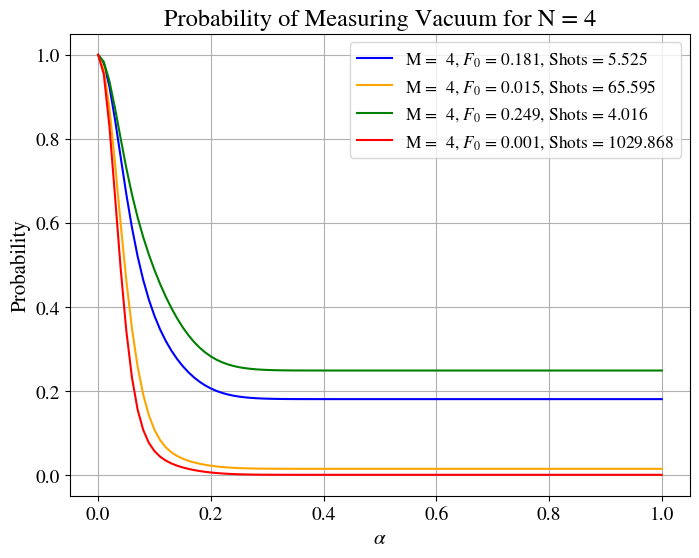

In [10]:
gs_amps, fidelity_array_list, shot_array_list = \
plot_exact_fidelity(N_cavities, α_start, α_end, α_steps, Es, m_start, m_stop, 
                    N_qubits, Jx, Jy, Jz, periodic_bc, tolerance, ψ0_list, save_file)